In [1]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.6 MB/s eta 0:00:00


In [2]:
from PIL import Image
from tqdm.auto import tqdm
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from torchvision import transforms

import json

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [3]:
# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

#4. the schedule algorithm used to "renoise" the image
scheduler = LMSDiscreteScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

# moving to GPU and halving precision for inference speed.
vae = vae.to(torch_device).half()
text_encoder = text_encoder.to(torch_device).half()
unet = unet.to(torch_device).half()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

We now define the parameters we'll use to generate images.

Note that `guidance_scale` is defined analog to the guidance weight `w` of equation (2) in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf). `guidance_scale == 1` corresponds to doing no classifier-free guidance. Here we set it to 7.5 as also done previously.

In contrast to the previous examples, we set `num_inference_steps` to 100 to get an even more defined image.

In [4]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

if not os.path.isdir('/content/drive/MyDrive/SD_outputs'):
  os.makedirs('/content/drive/MyDrive/SD_outputs')

output_dir='/content/drive/MyDrive/SD_outputs/'

Now, we use the first model (the text embedder) to turn the text input into a vector representation (text embedding).

In [9]:
#define embedding generation function for downstream use - this
def text_embedder(texts_list):
    text_input = tokenizer(texts_list, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

    text_embeddings=text_embeddings.sum(dim=0).reshape([1,77,768])
    text_embeddings=text_embeddings/len(texts_list)
    return text_embeddings

In [10]:
#define image import function, for downstream use
def injection_image2latent(image_str):
    injection=Image.open(image_str)
    injection=injection.resize((64,64))
    injection=injection.convert("RGBA")
    transform = transforms.Compose([
    transforms.PILToTensor()
        ])

    injectLatent=transform(injection).numpy()
    injectLatent=injectLatent.astype("float16")/255
    injectLatent=torch.Tensor(injectLatent).half()
    injectLatent=injectLatent.reshape([1,4,64,64]).to(torch_device)

    with torch.no_grad():
        noise_pred = unet(injectLatent, scheduler.init_noise_sigma, encoder_hidden_states=uncond_embeddings).sample

    latents = scheduler.step(noise_pred, scheduler.init_noise_sigma, injectLatent).prev_sample

    return latents


In [11]:
def latents2img(latents):
    latents = 1 / 0.18215 * latents
    latents = latents.half()
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    # print(images.shape)
    pil_images = [Image.fromarray(image) for image in images]

    pil_images[0]
    return pil_images[0]

In [12]:
#function for image generation
def StableDiffusion(uncond_input, text_input, height, width, num_inference_steps, guidance_scale, seed, image):
    text_embeddings=text_embedder(text_input)
    uncond_embeddings=text_embedder(uncond_input)


    batch_size=1

    generator=torch.manual_seed(seed)

    if not image:
        latents = torch.randn(
            (batch_size, unet.config.in_channels, height // 8, width // 8),
            generator=generator,
            )
    else:
        latents = injection_image2latent(image)

    latents = latents.to(torch_device)

    latents = latents * scheduler.init_noise_sigma

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    scheduler.set_timesteps(num_inference_steps)

    noisy_outputs_list=[]
    clean_outputs_list=[]
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, t).half()

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        all_latents = scheduler.step(noise_pred, t, latents)
        clean_latents = all_latents.pred_original_sample
        latents = all_latents.prev_sample
        #save intermediate decoded outputs, for viewing pleasure
        noisy_outputs_list.append(latents2img(latents))
        clean_outputs_list.append(latents2img(clean_latents))

    input_dict={
        'uncond_input': uncond_input,
        'text_input': text_input,
        'height': height,
        'width': width,
        'num_inference_steps': num_inference_steps,
        'guidance_scale': guidance_scale,
        'seed': seed,
        'image': image
    }
    return (noisy_outputs_list, clean_outputs_list, input_dict)

In [13]:
def save_outputs(output, dir):
    name = '--'.join(output[2]['text_input'])+'_'+str(output[2]['seed'])
    savedir=dir + name + '/'
    if not os.path.isdir(savedir):
      os.mkdir(savedir)
    output[0][0].save(savedir + 'noisy_output.gif',
               save_all=True, append_images=output[0][1:], optimize=False, duration=1, loop=0)
    output[1][0].save(savedir + 'clean_output.gif',
            save_all=True, append_images=output[1][1:], optimize=False, duration=1, loop=0)
    with open(savedir+"inputs.json", "w") as writefile:
      json.dump(output[2], writefile)


# ITERATE HERE

In [14]:
output=StableDiffusion(
    text_input=['Astronaut on a horse'],
    uncond_input=[''],
    height=512,
    width=512,
    num_inference_steps=10,
    guidance_scale=7.5,
    seed=42,
    image=False)

  0%|          | 0/10 [00:00<?, ?it/s]

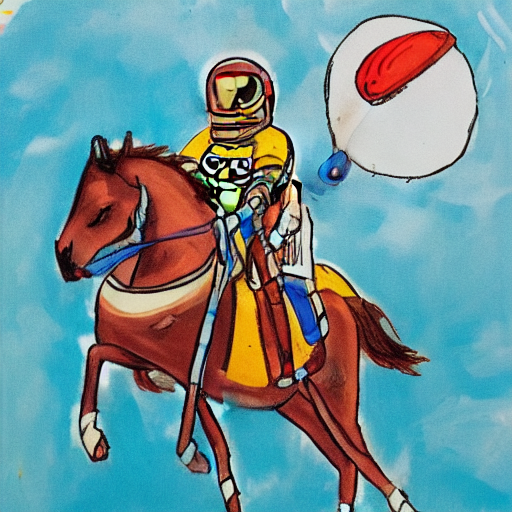

In [17]:
output[1][-1]

In [15]:
#if you like it - save the outputs here. NOTE: MAKE SURE YOU CHANGE THE OUTPUT NAME, OTHERWISE THE FILES WILL BE OVERWRITTEN
save_outputs(output, output_dir)

In [16]:
[]

[]